In [1]:
import time
from pathlib import Path
from operator import itemgetter

import scanpy as sc
import numpy as np
from sklearn.metrics import adjusted_rand_score, normalized_mutual_info_score
from scipy.sparse import csr_matrix
import pandas as pd
from joblib import Parallel, delayed
import os
import torch

import scSLAT
from scSLAT.model import run_SLAT_multi
from scSLAT.viz import build_3D
import scanpy as sc
import numpy as np
import pandas as pd

import scSLAT
from scSLAT.model import Cal_Spatial_Net, load_anndatas, run_SLAT_mlp_AGF, spatial_match, run_SLAT, compute_lisi_for_adata
from scSLAT.viz import match_3D_multi, hist, Sankey
from scSLAT.metrics import region_statistics


In [49]:
file_path_2 = os.path.join('D:/ppppaper/data/DLPFC/DLPFC/','151675')
adata_2 = sc.read_visium(path=file_path_2, count_file='filtered_feature_bc_matrix.h5', load_images=True)
adata_2.var_names_make_unique(join="++")

Ann_df_2 = pd.read_csv(os.path.join(file_path_2 , '151675_annotation.txt'),sep ='\t', header=0 , index_col=0)
Ann_df_2.loc[Ann_df_2['Layer'].isna(),'Layer'] = "unknown"
adata_2.obs['annotation'] = Ann_df_2.loc[adata_2.obs_names, 'Layer'].astype('category')

d:\Anaconda\envs\scSLAT\lib\site-packages\anndata\_core\anndata.py:1840: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
d:\Anaconda\envs\scSLAT\lib\site-packages\anndata\_core\anndata.py:1840: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


In [50]:
# 假设要打印第 i 行的信息
i = 218 # 可替换为任意行的索引

# 打印指定行的 obs_name 和 annotation
obs_name = adata_2.obs_names[i]
annotation = adata_2.obs['annotation'][i]

print(f"obs_name: {obs_name}, annotation: {annotation}")


obs_name: ACAAGTAATTGTAAGG-1, annotation: unknown


In [51]:
print(adata_2.obs_names)

Index(['AAACAACGAATAGTTC-1', 'AAACAAGTATCTCCCA-1', 'AAACACCAATAACTGC-1',
       'AAACAGAGCGACTCCT-1', 'AAACAGGGTCTATATT-1', 'AAACAGTGTTCCTGGG-1',
       'AAACATTTCCCGGATT-1', 'AAACCCGAACGAAATC-1', 'AAACCGGGTAGGTACC-1',
       'AAACCGTTCGTCCAGG-1',
       ...
       'TTGTGGTGGTACTAAG-1', 'TTGTGTATGCCACCAA-1', 'TTGTGTTTCCCGAAAG-1',
       'TTGTTAGCAAATTCGA-1', 'TTGTTCAGTGTGCTAC-1', 'TTGTTGTGTGTCAAGA-1',
       'TTGTTTCACATCCAGG-1', 'TTGTTTCATTAGTCTA-1', 'TTGTTTCCATACAACT-1',
       'TTGTTTGTATTACACG-1'],
      dtype='object', length=3592)


In [52]:
adata_2.obs['annotation']

AAACAACGAATAGTTC-1    Layer1
AAACAAGTATCTCCCA-1    Layer3
AAACACCAATAACTGC-1        WM
AAACAGAGCGACTCCT-1    Layer3
AAACAGGGTCTATATT-1    Layer5
                       ...  
TTGTTGTGTGTCAAGA-1    Layer5
TTGTTTCACATCCAGG-1        WM
TTGTTTCATTAGTCTA-1        WM
TTGTTTCCATACAACT-1    Layer6
TTGTTTGTATTACACG-1        WM
Name: annotation, Length: 3592, dtype: category
Categories (8, object): ['Layer1', 'Layer2', 'Layer3', 'Layer4', 'Layer5', 'Layer6', 'WM', 'unknown']

In [59]:
# 加载 .csv 文件
csv_data = pd.read_csv(r"D:\ppppaper\BANKSY\bansy_R\Banksy-bioc\Banksy-bioc\sample_151675_colData.csv", index_col=0)

# 定义映射字典
category_mapping = {
    1: "Layer1",
    2: "Layer2",
    3: "Layer3",
    4: "Layer4",
    5: "Layer5",
    6: "Layer6",
    7: "WM",
    8: "unknown"
}

# 映射 'clust_M0_lam0.2_k50_res0.7_smooth' 列
csv_data['banksy'] = csv_data['clust_M0_lam0.2_k50_res0.7_smooth'].map(category_mapping)

# 查看映射后的列
print(csv_data[['clust_M0_lam0.2_k50_res0.7_smooth', 'banksy']].head())


                    clust_M0_lam0.2_k50_res0.7_smooth   banksy
AAACAACGAATAGTTC-1                                  8  unknown
AAACAAGTATCTCCCA-1                                  3   Layer3
AAACACCAATAACTGC-1                                  7       WM
AAACAGAGCGACTCCT-1                                  2   Layer2
AAACAGGGTCTATATT-1                                  6   Layer6


In [60]:
# 加载 .csv 文件
csv_data_2 = pd.read_csv(r"D:\ppppaper\BANKSY\bansy_R\Banksy-bioc\Banksy-bioc\sample_151675_umap_only.csv", index_col=0)


# 查看映射后的列
print(csv_data_2.head())

                       UMAP_1     UMAP_2
AAACAACGAATAGTTC-1   2.372780 -11.760664
AAACAAGTATCTCCCA-1  -9.534208  -2.755843
AAACACCAATAACTGC-1  19.028011  -2.638460
AAACAGAGCGACTCCT-1  -9.162950  -6.829186
AAACAGGGTCTATATT-1   3.745464  11.239738


In [61]:
smooth_cluster_col = csv_data[['banksy']]
print(smooth_cluster_col.index.equals(adata_2.obs_names)) 
adata_2.obs['banksy'] = smooth_cluster_col

UMAP_1 = csv_data_2[['UMAP_1']]
UMAP_2 = csv_data_2[['UMAP_2']]
print(UMAP_1.index.equals(adata_2.obs_names)) 
print(UMAP_2.index.equals(adata_2.obs_names)) 
adata_2.obs['UMAP_1'] = UMAP_1
adata_2.obs['UMAP_2'] = UMAP_2


True
True
True


In [62]:
adata_2

AnnData object with n_obs × n_vars = 3592 × 33538
    obs: 'in_tissue', 'array_row', 'array_col', 'annotation', 'UMAP_1', 'UMAP_2', 'banksy'
    var: 'gene_ids', 'feature_types', 'genome'
    uns: 'spatial'
    obsm: 'spatial'

In [9]:
unique_categories = adata_2.obs['clust_M0_lam0.2_k50_res0.7_smooth'].unique()
print("Unique categories in 'clust_M0_lam0.2_k50_res0.7_smooth':", unique_categories)

Unique categories in 'clust_M0_lam0.2_k50_res0.7_smooth': ['unknown' 'Layer3' 'WM' 'Layer2' 'Layer6' 'Layer4' 'Layer5' 'Layer1']


In [64]:
# adata_2.write("./DFPLC_75_banksy_data.h5ad")

In [16]:
adata_2=sc.read_h5ad(r'D:\ppppaper\SLAT\SLAT-main\SLAT-main\my_benchmark\DFPLC_banksy.h5ad')
adata_2.var_names_make_unique(join="++")
adata_2

AnnData object with n_obs × n_vars = 3592 × 33538
    obs: 'in_tissue', 'array_row', 'array_col', 'annotation', 'clust_M0_lam0.2_k50_res0.7_smooth'
    var: 'gene_ids', 'feature_types', 'genome'
    uns: 'spatial'
    obsm: 'spatial'

In [25]:
# 假设要打印第 i 行的信息
i = 0 # 可替换为任意行的索引

# 打印指定行的 obs_name 和 annotation
obs_name = adata_2.obs_names[i]
annotation = adata_2.obs['annotation'][i]
cluster = adata_2.obs['clust_M0_lam0.2_k50_res0.7_smooth'][i]
print(f"obs_name: {obs_name}, annotation: {annotation}, cluster: {cluster}")

obs_name: AAACAACGAATAGTTC-1, annotation: Layer1, cluster: unknown


In [11]:
adata_2=sc.read_h5ad(r'D:\ppppaper\data\STARmap\20180417_BZ5_control.h5ad')
adata_2.var_names_make_unique(join="++")
adata_2

AnnData object with n_obs × n_vars = 1049 × 166
    obs: 'ct', 'region', 'Region', 'ground_truth'
    uns: 'ct_colors', 'region_colors'
    obsm: 'spatial'

In [12]:
print(adata_2.obs_names)

Index(['69x4486', '93x1063', '143x3445', '88x4092', '120x4293', '104x2648',
       '105x2425', '146x5387', '107x3104', '127x3822',
       ...
       '12234x921', '12214x741', '12235x4876', '12250x1559', '12260x3042',
       '12271x4981', '12290x6336', '12276x51', '12295x3331', '12261x1768'],
      dtype='object', length=1049)


In [18]:
csv_data = pd.read_csv(r"D:\ppppaper\BANKSY\Banksy_py-main\Banksy_py-main\data\starmap\tmp_png\leiden\seed1234\cell_cluster_labels.csv", index_col=0)

# 定义映射字典
category_mapping = {
    0: "4",
    1: "3",
    2: "2",
    3: "1"
}


csv_data['banksy'] = csv_data['cluster_label'].map(category_mapping)

# 查看映射后的列
print(csv_data[['banksy', 'cluster_label']].head())


         banksy  cluster_label
cell_id                       
69x4486       1              3
93x1063       1              3
143x3445      1              3
88x4092       1              3
120x4293      1              3


In [19]:
smooth_cluster_col = csv_data[['banksy']]
print(smooth_cluster_col.index.equals(adata_2.obs_names)) 
adata_2.obs['banksy'] = smooth_cluster_col

True


In [20]:
adata_2.obs['banksy']

69x4486       1
93x1063       1
143x3445      1
88x4092       1
120x4293      1
             ..
12271x4981    4
12290x6336    4
12276x51      4
12295x3331    4
12261x1768    4
Name: banksy, Length: 1049, dtype: object

In [21]:
unique_categories = adata_2.obs['banksy'].unique()
print("Unique categories in 'banksy':", unique_categories)

Unique categories in 'banksy': ['1' '2' '3' '4']


In [22]:
adata_2.write("./STARmap_banksy_data.h5ad")

In [33]:
adata_2=sc.read_h5ad('D:\ppppaper\data\MERFISH\MERFISH_0.19.h5ad')
adata_2.var_names_make_unique(join="++")

In [34]:
print(adata_2.obs_names)

Index(['1148x-733', '1150x-713', '1154x-761', '1162x-823', '1174x-690',
       '1179x-817', '1183x-857', '1187x-715', '1197x-860', '1202x-752',
       ...
       '2830x126', '2863x130', '2746x256', '2751x208', '2843x325', '2858x325',
       '2861x526', '2913x728', '2938x558', '2753x918'],
      dtype='object', name='Unnamed: 0', length=5803)


In [35]:
adata_2.obs['ground_truth']

Unnamed: 0
1148x-733    MPA
1150x-713    MPA
1154x-761    MPA
1162x-823    MPA
1174x-690    MPA
            ... 
2858x325     BST
2861x526     BST
2913x728     BST
2938x558     BST
2753x918      fx
Name: ground_truth, Length: 5803, dtype: category
Categories (8, object): ['BST', 'MPA', 'MPN', 'PV', 'PVH', 'PVT', 'V3', 'fx']

In [36]:
csv_data = pd.read_csv(r"D:\ppppaper\BANKSY\bansy_R\Banksy-bioc\Banksy-bioc\sample_19_colData.csv", index_col=0)

# 定义映射字典
# category_mapping = {
#     0: "BST",
#     1: "MPA",
#     2: "MPN",
#     3: "PVH",
#     4: "fx",
#     5: "PVT",
#     6: "PV",
#     7: "V3",
# }


# # csv_data['banksy'] = csv_data['cluster_label'].map(category_mapping)
csv_data['banksy'] = csv_data['cluster']

# 查看映射后的列
print(csv_data[['banksy', 'cluster']].head())

          banksy cluster
1148x-733  other   other
1150x-713  other   other
1154x-761  other   other
1162x-823  other   other
1174x-690    MPA     MPA


In [37]:
# 加载 .csv 文件
csv_data_2 = pd.read_csv(r"D:\ppppaper\BANKSY\bansy_R\Banksy-bioc\Banksy-bioc\sample_19_umap.csv", index_col=0)
# 查看映射后的列
print(csv_data_2.head())

              UMAP_1     UMAP_2
1148x-733  -4.800757  -8.461796
1150x-713   6.507852 -18.105449
1154x-761  -4.833518  -8.358317
1162x-823  16.623122 -16.164077
1174x-690   1.901366   0.829158


In [38]:
smooth_cluster_col = csv_data[['banksy']]
print(smooth_cluster_col.index.equals(adata_2.obs_names)) 
adata_2.obs['banksy'] = smooth_cluster_col


UMAP_1 = csv_data_2[['UMAP_1']]
UMAP_2 = csv_data_2[['UMAP_2']]

print(UMAP_1.index.equals(adata_2.obs_names)) 
print(UMAP_2.index.equals(adata_2.obs_names)) 
adata_2.obs['UMAP_1'] = UMAP_1
adata_2.obs['UMAP_2'] = UMAP_2


True
True
True


In [39]:
csv_data_3 = pd.read_csv(r"D:\ppppaper\BANKSY\bansy_R\Banksy-bioc\Banksy-bioc\sample_19_pca.csv", index_col=0)

# 查看映射后的列
print(csv_data_3.head())

                PC1       PC2       PC3       PC4       PC5       PC6  \
1148x-733  7.496007 -2.007015  0.420544 -0.694807  4.105949  1.223404   
1150x-713  6.533238 -3.041913 -0.284643  0.973830  2.745156  1.002979   
1154x-761  8.662103 -0.936670  0.848784 -1.881604  4.650350  1.609181   
1162x-823  5.778981  0.773049 -0.398033 -1.420516  1.114175 -3.656973   
1174x-690  2.985332 -2.224444  0.920607  0.248964  0.638905  1.657346   

                PC7        PC8        PC9      PC10      PC11      PC12  \
1148x-733 -1.574200  -3.105507   1.345106  3.986328  4.917019 -1.849835   
1150x-713 -1.861173  -1.897294   0.625993  1.792591  3.199428  0.101274   
1154x-761  0.264868  -6.555876  -0.744369  6.742407  6.389018  1.441290   
1162x-823  1.278342 -13.326556 -10.637643  7.674520  5.877869  2.227121   
1174x-690  0.133963  -1.816548   0.376837 -2.070891  0.069735  0.081663   

               PC13      PC14      PC15      PC16      PC17      PC18  \
1148x-733  0.872450  0.497248 -2.5529

In [40]:
pca_array = csv_data_3.values  # 转换为NumPy数组
pca_array

array([[ 7.49600696, -2.0070154 ,  0.42054399, ..., -1.42108691,
        -3.93438913,  0.2697023 ],
       [ 6.53323806, -3.04191264, -0.28464324, ..., -2.1126882 ,
        -3.25829963, -0.40685602],
       [ 8.66210261, -0.93666991,  0.84878351, ..., -2.0818006 ,
        -3.66708858,  1.03579598],
       ...,
       [ 1.51251701, -1.33424043,  0.30709266, ..., -0.75165577,
         0.82733892,  0.19984888],
       [ 0.79661036,  0.1213462 ,  2.36232242, ..., -1.65167178,
         0.64641417, -0.22891786],
       [ 4.83456197, -2.86514551, -2.58588556, ...,  3.09318158,
        -2.63124254,  1.6271916 ]])

In [41]:
adata_2.obsm["X_pca"] = pca_array

In [42]:
adata_2

AnnData object with n_obs × n_vars = 5803 × 155
    obs: 'cell_class', 'neuron_class', 'domain', 'Region', 'ground_truth', 'banksy', 'UMAP_1', 'UMAP_2'
    uns: 'domain_colors'
    obsm: 'spatial', 'X_pca'

In [ ]:
# adata_2.write("./MERFISH_19_banksy_data.h5ad")

In [45]:
adata_2=sc.read_h5ad('D:\ppppaper\data\MERFISH\MERFISH_0.14.h5ad')
adata_2.var_names_make_unique(join="++")

In [46]:
csv_data = pd.read_csv(r"D:\ppppaper\BANKSY\bansy_R\Banksy-bioc\Banksy-bioc\sample_14_colData.csv", index_col=0)
csv_data['banksy'] = csv_data['cluster']

# 查看映射后的列
print(csv_data[['banksy', 'cluster']].head())

           banksy cluster
-2914x-601  other   other
-2908x-509  other   other
-2904x-495  other   other
-2902x-540  other   other
-2893x-483  other   other


In [47]:
csv_data_2 = pd.read_csv(r"D:\ppppaper\BANKSY\bansy_R\Banksy-bioc\Banksy-bioc\sample_14_umap.csv", index_col=0)
# 查看映射后的列
print(csv_data_2.head())

              UMAP_1     UMAP_2
-2914x-601 -3.669894  -9.225950
-2908x-509 -3.232609  -8.974614
-2904x-495 -7.125791 -11.166333
-2902x-540 -7.034770 -11.118137
-2893x-483  7.287068 -18.293794


In [48]:
smooth_cluster_col = csv_data[['banksy']]
print(smooth_cluster_col.index.equals(adata_2.obs_names)) 
adata_2.obs['banksy'] = smooth_cluster_col


UMAP_1 = csv_data_2[['UMAP_1']]
UMAP_2 = csv_data_2[['UMAP_2']]

print(UMAP_1.index.equals(adata_2.obs_names)) 
print(UMAP_2.index.equals(adata_2.obs_names)) 
adata_2.obs['UMAP_1'] = UMAP_1
adata_2.obs['UMAP_2'] = UMAP_2

True
True
True


In [49]:
csv_data_3 = pd.read_csv(r"D:\ppppaper\BANKSY\bansy_R\Banksy-bioc\Banksy-bioc\sample_14_pca.csv", index_col=0)

# 查看映射后的列
print(csv_data_3.head())

                 PC1       PC2       PC3       PC4       PC5       PC6  \
-2914x-601  7.118689 -1.828276  0.978075 -1.447065  2.287672  0.344951   
-2908x-509  7.425891 -2.254866 -0.017698 -0.536904  1.310036 -0.605949   
-2904x-495  7.148087 -2.338039 -0.154161 -0.111230  1.099140  0.132889   
-2902x-540  7.221415 -2.246092  0.331904 -0.858914  1.697184 -0.129851   
-2893x-483  7.293143 -2.719547 -0.680601  0.465296  0.918667 -0.792892   

                 PC7       PC8       PC9      PC10      PC11      PC12  \
-2914x-601 -1.413594 -4.251937  4.007344 -3.066234 -1.020560  1.658712   
-2908x-509 -0.681675 -4.404329  2.611756 -3.361760 -1.648646  2.592435   
-2904x-495 -0.325654 -3.228188  2.083529 -1.433754  0.844477 -5.140759   
-2902x-540 -1.024448 -4.448092  2.548604 -1.899151  0.206183 -4.921208   
-2893x-483 -1.200372 -3.384569  1.356955 -2.647831 -0.202892  0.054152   

                PC13      PC14      PC15      PC16      PC17      PC18  \
-2914x-601 -1.904242 -0.199731  0.17

In [50]:
pca_array = csv_data_3.values  # 转换为NumPy数组
pca_array

array([[ 7.11868915, -1.82827558,  0.97807548, ..., -0.66813892,
         1.75508623,  0.64300038],
       [ 7.42589091, -2.25486629, -0.01769785, ...,  0.07968042,
         2.22212224,  0.45385272],
       [ 7.14808681, -2.3380394 , -0.15416147, ...,  0.5575559 ,
         2.14791102,  0.15674534],
       ...,
       [-2.95248692, -0.4225565 ,  4.43888828, ...,  0.4877858 ,
         1.00622147, -1.09476823],
       [ 4.57672727, -3.3164687 , -2.01706886, ..., -1.67642835,
        -0.86772661, -0.54951529],
       [-1.66849923, -0.98931068,  3.70815406, ..., -0.0198772 ,
         0.62528827, -0.75139564]])

In [51]:
adata_2.obsm["X_pca"] = pca_array

In [ ]:
# adata_2.write("./MERFISH_14_banksy_data.h5ad")

In [51]:
adata_2=sc.read_h5ad('D:\ppppaper\data\BARISTAseq\Slice_3.h5ad')
adata_2.var_names_make_unique(join="++")
print(adata_2.obs_names)

Index(['520015', '520022', '520028', '520029', '520030', '520040', '520046',
       '520050', '520054', '520061',
       ...
       '730144', '730145', '730146', '730147', '730148', '730150', '730153',
       '730154', '730156', '730158'],
      dtype='object', length=1690)


In [52]:
adata_2.obs['ground_truth']

520015        VISp_VI
520022        VISp_VI
520028        VISp_VI
520029        VISp_VI
520030        VISp_VI
             ...     
730150    VISp_II/III
730153    VISp_II/III
730154    VISp_II/III
730156    VISp_II/III
730158    VISp_II/III
Name: ground_truth, Length: 1690, dtype: category
Categories (6, object): ['VISp_I', 'VISp_II/III', 'VISp_IV', 'VISp_V', 'VISp_VI', 'VISp_wm']

In [53]:
csv_data = pd.read_csv(r"D:\ppppaper\BANKSY\bansy_R\Banksy-bioc\Banksy-bioc\BARISTA_slice3_colData.csv", index_col=0)
csv_data['banksy'] = csv_data['cluster']

# 查看映射后的列
print(csv_data[['banksy', 'cluster']].head())

         banksy  cluster
520015  VISp_wm  VISp_wm
520022  VISp_VI  VISp_VI
520028  VISp_VI  VISp_VI
520029  VISp_VI  VISp_VI
520030  VISp_VI  VISp_VI


In [54]:
# 加载 .csv 文件
csv_data_2 = pd.read_csv(r"D:\ppppaper\BANKSY\bansy_R\Banksy-bioc\Banksy-bioc\BARISTA_slice3_umap.csv", index_col=0)
# 查看映射后的列
print(csv_data_2.head())

          UMAP_1    UMAP_2
520015  6.591750 -4.283468
520022  2.877254 -9.298690
520028  3.152415 -9.897162
520029  3.215178 -9.338506
520030  2.434319 -9.721064


In [55]:
adata_2.obs_names

Index(['520015', '520022', '520028', '520029', '520030', '520040', '520046',
       '520050', '520054', '520061',
       ...
       '730144', '730145', '730146', '730147', '730148', '730150', '730153',
       '730154', '730156', '730158'],
      dtype='object', length=1690)

In [56]:
smooth_cluster_col = csv_data[['banksy']]
clu_col_1 = smooth_cluster_col.index.map(str)
smooth_cluster_col = smooth_cluster_col.set_index(clu_col_1)
print(clu_col_1.equals(adata_2.obs_names)) 
adata_2.obs['banksy'] = smooth_cluster_col


UMAP_1 = csv_data_2[['UMAP_1']]
UMAP_2 = csv_data_2[['UMAP_2']]
clu_col_2 = UMAP_1.index.map(str)
clu_col_3 = UMAP_2.index.map(str)
UMAP_1 = UMAP_1.set_index(clu_col_2)
UMAP_2 = UMAP_2.set_index(clu_col_3)
print(clu_col_2.equals(adata_2.obs_names)) 
print(clu_col_3.equals(adata_2.obs_names)) 
adata_2.obs['UMAP_1'] = UMAP_1
adata_2.obs['UMAP_2'] = UMAP_2

True
True
True


In [57]:
csv_data_3 = pd.read_csv(r"D:\ppppaper\BANKSY\bansy_R\Banksy-bioc\Banksy-bioc\BARISTA_slice3_pca.csv", index_col=0)
print(csv_data_3.head())

             PC1       PC2       PC3       PC4       PC5       PC6       PC7  \
520015  2.644566  0.229631  1.775459  0.513098 -0.582833 -0.135388  0.031958   
520022 -1.028598 -1.224297  1.131163  0.481544  0.873819 -0.355290 -0.026249   
520028 -1.243003 -1.787293  1.663242  0.559541  0.996511 -0.342749  0.091137   
520029 -0.382994 -1.448964  1.333059  0.334255  1.812717  0.139717  0.053187   
520030 -1.475290 -1.647233  0.896847 -0.217583  1.376504 -0.214244  0.490363   

             PC8       PC9      PC10      PC11      PC12      PC13      PC14  \
520015  0.319321  0.070972 -0.321347  2.187955  0.804710 -0.013547 -0.744583   
520022 -0.362008 -0.067848 -0.703931  0.659934 -0.118728  0.619300  0.698384   
520028 -0.413619 -0.357754 -0.487327  0.697868  0.330310  0.094824  0.768733   
520029 -0.391307 -0.302333 -0.313189 -0.000460 -0.433036 -0.247616  0.050853   
520030 -0.071009 -0.235792 -0.195047 -0.391883 -0.689585  0.455513  0.581646   

            PC15      PC16      PC17  

In [58]:
pca_array = csv_data_3.values  # 转换为NumPy数组
adata_2.obsm["X_pca"] = pca_array

In [59]:
adata_2

AnnData object with n_obs × n_vars = 1690 × 79
    obs: 'Slice', 'x', 'y', 'Dist to pia', 'Dist to bottom', 'Angle', 'unused-1', 'unused-2', 'x_um', 'y_um', 'depth_um', 'layer', 'Region', 'ground_truth', 'banksy', 'UMAP_1', 'UMAP_2'
    uns: 'layer_colors'
    obsm: 'spatial', 'X_pca'

In [ ]:
# adata_2.write("./BARISTA_slice3_banksy_data.h5ad")

In [70]:
adata_2=sc.read_h5ad(r"D:\ppppaper\data\STARmap\20180419_BZ9_control.h5ad")
adata_2.var_names_make_unique(join="++")

In [71]:
csv_data = pd.read_csv(r"D:\ppppaper\BANKSY\bansy_R\Banksy-bioc\Banksy-bioc\STARMAP_sample_9_colData.csv", index_col=0)

category_mapping = {
    1: "3",
    2: "4",
    3: "1",
    4: "2"
}

csv_data['banksy'] = csv_data['clust_M0_lam0.9_k50_res0.4_smooth'].map(category_mapping)

# 查看映射后的列
print(csv_data[['banksy', 'clust_M0_lam0.9_k50_res0.4_smooth']].head())

         banksy  clust_M0_lam0.9_k50_res0.4_smooth
44x5377       1                                  3
68x4194       1                                  3
84x5959       1                                  3
80x5764       1                                  3
114x1974      1                                  3


In [72]:
# 加载 .csv 文件
csv_data_2 = pd.read_csv(r"D:\ppppaper\BANKSY\bansy_R\Banksy-bioc\Banksy-bioc\STARMAP_sample_9_umap.csv", index_col=0)
# 查看映射后的列
print(csv_data_2.head())

            UMAP_1     UMAP_2
44x5377   1.159583 -16.843864
68x4194   2.892943 -13.534240
84x5959   1.039964 -16.909067
80x5764   1.037473 -17.126615
114x1974  0.384528 -11.103262


In [73]:
smooth_cluster_col = csv_data[['banksy']]
print(smooth_cluster_col.index.equals(adata_2.obs_names)) 
adata_2.obs['banksy'] = smooth_cluster_col


UMAP_1 = csv_data_2[['UMAP_1']]
UMAP_2 = csv_data_2[['UMAP_2']]

print(UMAP_1.index.equals(adata_2.obs_names)) 
print(UMAP_2.index.equals(adata_2.obs_names)) 
adata_2.obs['UMAP_1'] = UMAP_1
adata_2.obs['UMAP_2'] = UMAP_2

True
True
True


In [74]:
csv_data_3 = pd.read_csv(r"D:\ppppaper\BANKSY\bansy_R\Banksy-bioc\Banksy-bioc\STARMAP_sample_9_pca.csv", index_col=0)
print(csv_data_3.head())

                PC1       PC2       PC3       PC4       PC5       PC6  \
44x5377   -8.656497  1.507417  1.044784  1.973716  4.051276  2.287957   
68x4194  -10.234847  1.326104  3.104726  2.593276  7.096483  2.278085   
84x5959   -8.708324  1.269194  0.731624  3.371021  3.631602  3.238815   
80x5764   -8.369550  1.718189  0.564208  2.556508  3.028474  2.224851   
114x1974 -10.445512  0.612972  1.423235 -3.914410  2.138130  2.818579   

               PC7       PC8       PC9      PC10      PC11      PC12  \
44x5377  -1.075552 -6.205278 -0.749835  5.200473  4.311996 -2.984497   
68x4194  -6.263566 -1.879642  3.344227  1.086524 -0.126210 -1.273405   
84x5959  -0.536541 -6.910671 -0.675345  6.837171  5.043746 -2.847110   
80x5764  -0.386471 -6.244565 -0.457639  7.704007  3.776778 -3.085514   
114x1974 -0.567460  0.227542 -0.822331  2.953239 -2.801580 -2.662826   

              PC13      PC14      PC15      PC16      PC17      PC18  \
44x5377  -1.683535 -0.797178 -1.076250 -3.571997  1.3327

In [75]:
pca_array = csv_data_3.values  # 转换为NumPy数组
adata_2.obsm["X_pca"] = pca_array

In [76]:
adata_2

AnnData object with n_obs × n_vars = 1053 × 166
    obs: 'ct', 'region', 'Region', 'ground_truth', 'banksy', 'UMAP_1', 'UMAP_2'
    uns: 'ct_colors', 'region_colors'
    obsm: 'spatial', 'X_pca'

In [ ]:
# adata_2.write("./STARMAP_9_banksy_data.h5ad")

In [91]:
file_path_1 = os.path.join('D:/ppppaper/data/DLPFC/DLPFC/','151674')
adata_1 = sc.read_visium(path=file_path_1, count_file='filtered_feature_bc_matrix.h5', load_images=True)
adata_1.var_names_make_unique(join="++")

Ann_df_1 = pd.read_csv(os.path.join(file_path_1 , '151674_annotation.txt'),sep ='\t', header=0 , index_col=0)
Ann_df_1.loc[Ann_df_1['Layer'].isna(),'Layer'] = "unknown"
adata_1.obs['annotation'] = Ann_df_1.loc[adata_1.obs_names, 'Layer'].astype('category')

d:\Anaconda\envs\scSLAT\lib\site-packages\anndata\_core\anndata.py:1840: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
d:\Anaconda\envs\scSLAT\lib\site-packages\anndata\_core\anndata.py:1840: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


In [92]:
print(adata_1.obs_names)

Index(['AAACAAGTATCTCCCA-1', 'AAACAATCTACTAGCA-1', 'AAACACCAATAACTGC-1',
       'AAACAGAGCGACTCCT-1', 'AAACAGCTTTCAGAAG-1', 'AAACAGGGTCTATATT-1',
       'AAACAGTGTTCCTGGG-1', 'AAACATTTCCCGGATT-1', 'AAACCCGAACGAAATC-1',
       'AAACCGGGTAGGTACC-1',
       ...
       'TTGTGTATGCCACCAA-1', 'TTGTGTTTCCCGAAAG-1', 'TTGTTAGCAAATTCGA-1',
       'TTGTTCAGTGTGCTAC-1', 'TTGTTGTGTGTCAAGA-1', 'TTGTTTCACATCCAGG-1',
       'TTGTTTCATTAGTCTA-1', 'TTGTTTCCATACAACT-1', 'TTGTTTGTATTACACG-1',
       'TTGTTTGTGTAAATTC-1'],
      dtype='object', length=3673)


In [93]:
adata_1.obs['annotation']

AAACAAGTATCTCCCA-1    Layer3
AAACAATCTACTAGCA-1    Layer1
AAACACCAATAACTGC-1        WM
AAACAGAGCGACTCCT-1    Layer3
AAACAGCTTTCAGAAG-1    Layer5
                       ...  
TTGTTTCACATCCAGG-1        WM
TTGTTTCATTAGTCTA-1        WM
TTGTTTCCATACAACT-1    Layer6
TTGTTTGTATTACACG-1        WM
TTGTTTGTGTAAATTC-1    Layer1
Name: annotation, Length: 3673, dtype: category
Categories (8, object): ['Layer1', 'Layer2', 'Layer3', 'Layer4', 'Layer5', 'Layer6', 'WM', 'unknown']

In [80]:
csv_data = pd.read_csv(r"D:\ppppaper\BANKSY\bansy_R\Banksy-bioc\Banksy-bioc\sample_151674_dfplc_banksy.csv", index_col=0)

# 定义映射字典
category_mapping = {
    1: "Layer1",
    2: "Layer2",
    3: "Layer3",
    4: "Layer4",
    5: "Layer5",
    6: "Layer6",
    7: "WM",
    8: "unknown"
}


csv_data['banksy'] = csv_data['clust_M0_lam0.2_k50_res0.7_smooth'].map(category_mapping)

# 查看映射后的列
print(csv_data[['banksy', 'clust_M0_lam0.2_k50_res0.7_smooth']].head())

                     banksy  clust_M0_lam0.2_k50_res0.7_smooth
AAACAAGTATCTCCCA-1   Layer2                                  2
AAACAATCTACTAGCA-1  unknown                                  8
AAACACCAATAACTGC-1       WM                                  7
AAACAGAGCGACTCCT-1   Layer3                                  3
AAACAGCTTTCAGAAG-1   Layer6                                  6


In [83]:
# 加载 .csv 文件
csv_data_2 = pd.read_csv(r"D:\ppppaper\BANKSY\bansy_R\Banksy-bioc\Banksy-bioc\sample_151674_umap_only.csv", index_col=0)

# 查看映射后的列
print(csv_data_2.head())
csv_data_2.shape

                       UMAP_1     UMAP_2
AAACAAGTATCTCCCA-1  -9.949911  -7.661912
AAACAATCTACTAGCA-1  -1.001147  -9.557329
AAACACCAATAACTGC-1  20.219358  -1.184793
AAACAGAGCGACTCCT-1  -6.694260  -5.832923
AAACAGCTTTCAGAAG-1   7.811384  13.620062


(3673, 2)

In [ ]:
csv_data_3 = pd.read_csv(r"D:\ppppaper\BANKSY\bansy_R\Banksy-bioc\Banksy-bioc\sample_151674_pca.csv", index_col=0)

# 查看映射后的列
print(csv_data_3.head())

                PC1       PC2       PC3       PC4       PC5       PC6  \
1148x-733  7.496007 -2.007015  0.420544 -0.694807  4.105949  1.223404   
1150x-713  6.533238 -3.041913 -0.284643  0.973830  2.745156  1.002979   
1154x-761  8.662103 -0.936670  0.848784 -1.881604  4.650350  1.609181   
1162x-823  5.778981  0.773049 -0.398033 -1.420516  1.114175 -3.656973   
1174x-690  2.985332 -2.224444  0.920607  0.248964  0.638905  1.657346   

                PC7        PC8        PC9      PC10      PC11      PC12  \
1148x-733 -1.574200  -3.105507   1.345106  3.986328  4.917019 -1.849835   
1150x-713 -1.861173  -1.897294   0.625993  1.792591  3.199428  0.101274   
1154x-761  0.264868  -6.555876  -0.744369  6.742407  6.389018  1.441290   
1162x-823  1.278342 -13.326556 -10.637643  7.674520  5.877869  2.227121   
1174x-690  0.133963  -1.816548   0.376837 -2.070891  0.069735  0.081663   

               PC13      PC14      PC15      PC16      PC17      PC18  \
1148x-733  0.872450  0.497248 -2.5529

In [88]:
smooth_cluster_col = csv_data[['banksy']]
print(smooth_cluster_col.index.equals(adata_1.obs_names)) 
adata_1.obs['banksy'] = smooth_cluster_col


UMAP_1 = csv_data_2[['UMAP_1']]
UMAP_2 = csv_data_2[['UMAP_2']]

print(UMAP_1.index.equals(adata_1.obs_names)) 
print(UMAP_2.index.equals(adata_1.obs_names)) 
adata_1.obs['UMAP_1'] = UMAP_1
adata_1.obs['UMAP_2'] = UMAP_2


True
True
True


In [89]:
adata_1

AnnData object with n_obs × n_vars = 3673 × 33538
    obs: 'in_tissue', 'array_row', 'array_col', 'annotation', 'banksy', 'UMAP_1', 'UMAP_2'
    var: 'gene_ids', 'feature_types', 'genome'
    uns: 'spatial'
    obsm: 'spatial'

In [90]:
# adata_1.write("./DFPLC_74_banksy_data.h5ad")

In [102]:
adata_1=sc.read_h5ad(r"D:\ppppaper\SLAT\SLAT-main\SLAT-main\my_benchmark\DFPLC_75_banksy_data.h5ad")
adata_1.var_names_make_unique(join="++")
adata_1

AnnData object with n_obs × n_vars = 3592 × 33538
    obs: 'in_tissue', 'array_row', 'array_col', 'annotation', 'UMAP_1', 'UMAP_2', 'banksy'
    var: 'gene_ids', 'feature_types', 'genome'
    uns: 'spatial'
    obsm: 'spatial'

In [103]:
csv_data_3 = pd.read_csv(r"D:\ppppaper\BANKSY\bansy_R\Banksy-bioc\Banksy-bioc\sample_151675_pca.csv", index_col=0)

# 查看映射后的列
print(csv_data_3.head())
csv_data_3.shape

                          PC1       PC2       PC3       PC4       PC5  \
AAACAACGAATAGTTC-1   3.371177  3.660609 -2.945424 -1.542166  2.082193   
AAACAAGTATCTCCCA-1   6.459317 -1.880939  1.640113  1.840955 -0.446061   
AAACACCAATAACTGC-1 -25.325557 -0.065944  1.469249 -0.113833 -0.948965   
AAACAGAGCGACTCCT-1   6.770309  0.304997  3.618557  0.109803 -1.012552   
AAACAGGGTCTATATT-1   2.438169 -1.335909 -4.148565 -0.909943 -1.132829   

                          PC6       PC7       PC8       PC9      PC10  \
AAACAACGAATAGTTC-1  11.643045  4.402474  1.984185 -8.128013  2.017927   
AAACAAGTATCTCCCA-1   1.605716  0.146086 -1.256945  0.410533  2.161210   
AAACACCAATAACTGC-1   0.324917 -0.742520 -0.430087  1.157596  1.627576   
AAACAGAGCGACTCCT-1   0.147489 -0.149639 -2.951995 -0.840688 -3.896456   
AAACAGGGTCTATATT-1  -2.714220  1.139477  0.642825 -0.796405  2.417545   

                        PC11      PC12      PC13      PC14      PC15  \
AAACAACGAATAGTTC-1 -3.493763 -1.884030  2.720910 -

(3592, 20)

In [104]:
pca_array = csv_data_3.values  # 转换为NumPy数组
pca_array

array([[  3.37117697,   3.6606092 ,  -2.94542393, ...,   2.43144944,
          1.86481898,  -2.22023864],
       [  6.45931714,  -1.88093935,   1.64011283, ...,  -0.43548862,
          1.39259675,   0.56381768],
       [-25.32555738,  -0.06594363,   1.46924857, ...,  -2.19221515,
          0.29584683,  -0.75246129],
       ...,
       [-26.90833376,  -2.40974801,   2.93810298, ...,   1.95543774,
          0.82155244,   0.59006119],
       [  3.35419366,  -1.18286059,  -5.28991454, ...,   1.26943353,
         -2.59311668,  -1.69716729],
       [-13.29284462,  -0.62570158,  -0.35090507, ...,  -0.04975465,
         -0.96987517,   0.55850997]])

In [105]:
adata_1.obsm["X_pca"] = pca_array

In [106]:
adata_1

AnnData object with n_obs × n_vars = 3592 × 33538
    obs: 'in_tissue', 'array_row', 'array_col', 'annotation', 'UMAP_1', 'UMAP_2', 'banksy'
    var: 'gene_ids', 'feature_types', 'genome'
    uns: 'spatial'
    obsm: 'spatial', 'X_pca'

In [107]:
# adata_1.write("./DFPLC_75_banksy_data.h5ad")

In [24]:
adata_1=sc.read_h5ad('D:\ppppaper\data\BrCa\BRCA_Section_2.h5ad')
adata_1.var_names_make_unique(join="++")
adata_1

AnnData object with n_obs × n_vars = 3987 × 36601
    obs: 'in_tissue', 'array_row', 'array_col', 'Cell_type'
    var: 'gene_ids', 'feature_types', 'genome'
    uns: 'spatial'
    obsm: 'spatial'

In [25]:
print(adata_1.obs_names)

Index(['AAACAACGAATAGTTC-1', 'AAACAAGTATCTCCCA-1', 'AAACAATCTACTAGCA-1',
       'AAACACCAATAACTGC-1', 'AAACAGAGCGACTCCT-1', 'AAACAGCTTTCAGAAG-1',
       'AAACAGGGTCTATATT-1', 'AAACAGTGTTCCTGGG-1', 'AAACATTTCCCGGATT-1',
       'AAACCACTACACAGAT-1',
       ...
       'TTGTGTATGCCACCAA-1', 'TTGTGTTTCCCGAAAG-1', 'TTGTTAGCAAATTCGA-1',
       'TTGTTCAGTGTGCTAC-1', 'TTGTTGTGTGTCAAGA-1', 'TTGTTTCACATCCAGG-1',
       'TTGTTTCATTAGTCTA-1', 'TTGTTTCCATACAACT-1', 'TTGTTTGTATTACACG-1',
       'TTGTTTGTGTAAATTC-1'],
      dtype='object', length=3987)


In [26]:
csv_data = pd.read_csv("D:\ppppaper\data\BrCa\section_2-new.csv", index_col=0)
csv_data.head(5)

,tumor_region_real
AAGGAGAACTTATAAG-1,Carcinoma in situ 1
AATAAGTCCTCGAGAC-1,Carcinoma in situ 1
ACAAACCGACAAGGCG-1,Carcinoma in situ 1
ACAATCGATCTTTATA-1,Carcinoma in situ 1
ACATCTCAACGCGTAA-1,Carcinoma in situ 1


In [27]:
print(csv_data.index.equals(adata_1.obs_names))
# 找出在 CSV 文件中但不在 AnnData 中的行名称
csv_not_in_adata = csv_data.index.difference(adata_1.obs_names)
print("In CSV but not in AnnData:", csv_not_in_adata)

# 找出在 AnnData 中但不在 CSV 文件中的行名称
adata_not_in_csv = adata_1.obs_names.difference(csv_data.index)
print("In AnnData but not in CSV:", adata_not_in_csv)

False
In CSV but not in AnnData: Index([], dtype='object')
In AnnData but not in CSV: Index([], dtype='object')


In [28]:
# 检查 AnnData 中的重复索引
duplicate_obs_names = adata_1.obs_names[adata_1.obs_names.duplicated()]
print("Duplicate indices in AnnData:", duplicate_obs_names)

# 检查 CSV 文件中的重复索引
duplicate_csv_indices = csv_data.index[csv_data.index.duplicated()]
print("Duplicate indices in CSV:", duplicate_csv_indices)


Duplicate indices in AnnData: Index([], dtype='object')
Duplicate indices in CSV: Index(['CCTGTCACCCGGGCTC-1', 'GACACAAGGGAAGAAA-1', 'GCTAACTGAAGTCTGA-1',
       'GGCGCGGAGATCTTTC-1', 'CTAGTAGAAAGGGATT-1', 'GGCGTAGGGAAAGCTG-1',
       'TATCCGCACCGTCGGG-1', 'TCGTCTTAGGCGTTAA-1'],
      dtype='object')


In [29]:
# 删除 CSV 文件中重复的行，只保留第一次出现的行
csv_data = csv_data[~csv_data.index.duplicated(keep='first')]

# 再次检查是否还有重复索引
print(csv_data.index.duplicated().sum())  # 这应该返回 0，表示没有重复项


0


In [30]:
# 重新排序 CSV 数据的行顺序，以匹配 AnnData 对象
csv_data = csv_data.reindex(adata_1.obs_names)

# 确保重新排序后的索引完全匹配
print(csv_data.index.equals(adata_1.obs_names))  # 这应该返回 True

# 将 CSV 数据整合到 AnnData 对象的 obs 中
adata_1.obs = adata_1.obs.join(csv_data)

# 检查整合后的结果
print(adata_1.obs.head())


True
                    in_tissue  array_row  array_col Cell_type  \
AAACAACGAATAGTTC-1          1          0         16     other   
AAACAAGTATCTCCCA-1          1         50        102     other   
AAACAATCTACTAGCA-1          1          3         43         4   
AAACACCAATAACTGC-1          1         59         19         1   
AAACAGAGCGACTCCT-1          1         14         94         8   

                       tumor_region_real  
AAACAACGAATAGTTC-1  Invasive carcinoma 1  
AAACAAGTATCTCCCA-1                 other  
AAACAATCTACTAGCA-1  Invasive carcinoma 1  
AAACACCAATAACTGC-1  Invasive carcinoma 5  
AAACAGAGCGACTCCT-1                 other  


In [31]:
adata_1

AnnData object with n_obs × n_vars = 3987 × 36601
    obs: 'in_tissue', 'array_row', 'array_col', 'Cell_type', 'tumor_region_real'
    var: 'gene_ids', 'feature_types', 'genome'
    uns: 'spatial'
    obsm: 'spatial'

[<AxesSubplot: xlabel='spatial1', ylabel='spatial2'>]

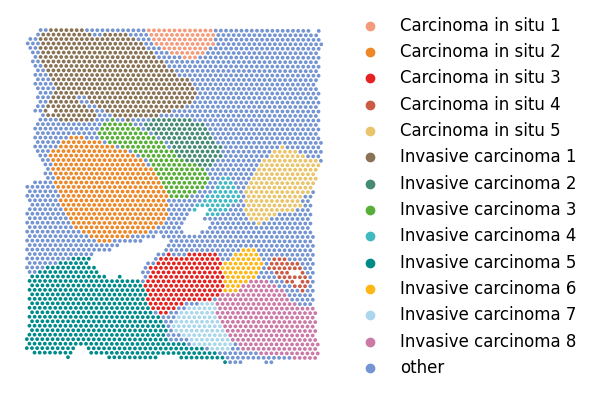

In [32]:
spot_size = 200
pathology_color = ["#F59B7B", "#ED8828", "#E42320", "#CC5B45", "#E9C46A", "#8A7355", "#458A74",
                   "#57AF37", "#41B9C1", "#008B8B", "#FDB815", "#ABD7EC", "#CB79A6", "#7494D2"]

sc.pl.spatial(adata_1, img_key=None, color=['tumor_region_real'], title=[''],
                legend_fontsize=12, show=False, frameon=False, palette=pathology_color,
                spot_size=spot_size)

In [33]:
adata_1.obs['tumor_region'] = adata_1.obs['tumor_region_real'].map({
    'Carcinoma in situ 1': 'CIS',
    'Carcinoma in situ 2': 'CIS',
    'Carcinoma in situ 3': 'CIS',
    'Carcinoma in situ 4': 'CIS',
    'Carcinoma in situ 5': 'CIS',
    'Invasive carcinoma 1': 'IC',
    'Invasive carcinoma 2': 'IC',
    'Invasive carcinoma 3': 'IC',
    'Invasive carcinoma 4': 'IC',
    'Invasive carcinoma 5': 'IC',
    'Invasive carcinoma 6': 'IC',
    'Invasive carcinoma 7': 'IC',
    'Invasive carcinoma 8': 'IC',
    'other': 'other'
})

[<AxesSubplot: xlabel='spatial1', ylabel='spatial2'>]

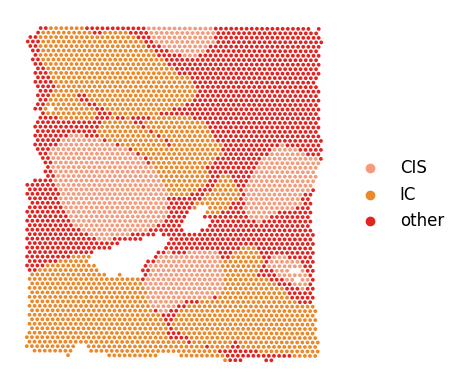

In [34]:
sc.pl.spatial(adata_1, img_key=None, color=['tumor_region'], title=[''],
                legend_fontsize=12, show=False, frameon=False, palette=pathology_color,
                spot_size=spot_size)

In [35]:
adata_1.write('./BrCa_section2_add_tumor_region.h5ad')